# Preliminaries

Before running anything in this notebook, you must first start your cluster.  Do this in the "IPython clusters" tab of the file browser page (you can get to the file browser by clicking on the jupyter icon in the upper left corner of the page, but you probably have it open in another tab already).

When the cluster is started, execute the following code to see how many compute engines you have.

In [1]:
from ipyparallel import Client

In [50]:
# replace CQM here with the name of the cluster you started
clustername = "CQM"

# construct a way for us to interact with the cluster
rc = Client(profile=clustername)

In [52]:
# how long is the list of worker ids?
len(rc.ids)

74

I asked for 80 engines, so I ought to have that many, but we don't always get all of them, for some reason (I'll have to look into that at some point).

# If you get any kind of error before reaching this point, you need to fix it before proceeding.


## The paradigm

There's more than one paradigm for working in parallel, but we will be using the simplest one.  We will package the work we want done into chunks which can be sent to *workers* (or *compute nodes*); the workers will execute what we send them and send back the results.

For this to function properly, we need three things:
1. We need a collection of packaged bits of work to send to the compute nodes;
2. We need a way to send the work to the compute nodes; and 
3. We need a way to manage the results that come back.

Let's deal with these in order.

### Packaging work for remote execution

First, something simple, just to show how this works. Since we're going to be running on multiple machines, let's try a simple function that tells us where it's executing. I should also keep track of which task is executing, since we'll be working with multiple tasks.

In [4]:
def where_executed(taskid=0):
    """Returns the POSIX nodename and working directory."""
    import os
    
    nodename = os.uname()[1]
    cwd = os.getcwd()
    
    return "Task {} on {}: {}".format(taskid, nodename, cwd)

where_executed()

'Task 0 on atlacamani: /home/cmckay/multipendulum'

A couple of features make this function well suited for the kind of parallel execution we will be using.
1. It is entirely self-contained. That is, it imports whatever modules are needed for it to run.
2. It takes a single argument.

Neither of these features is necessary to run in parallel, but they make life easier for the way we are approaching it.

### Passing out work

You've already seen the first part of what is necessary for passing out parallel work: a *client*. In our case, we have given the client the name `rc`.  The client represents the cluster as a whole. If we want to interact with the engines in any meaningful way, we will need to create a *view* on this client (that is, a way to access the engines).

There are two main kinds of views: direct and load-balanced. If you choose the direct view, you will control which jobs get sent to which engines. In the load balanced view, a bit of software called a load-balancer sends roughly equal amounts of work to each engine. You will nearly always want the load balanced view.

In [53]:
# could use rc.direct_view() instead
lbv = rc.load_balanced_view()

Let's run 20 instances of our `where_executed` function on the cluster. To keep track of which is which, I'll create a list of `task_ids` and [`map`](https://docs.python.org/3.6/library/functions.html#map) the `where_executed` function onto this list.  I will do this *synchronously*, which just means that I'll need to wait for the results before proceeding.

In [6]:
task_ids = list(range(20))
result = lbv.map_sync(where_executed, task_ids)

### Managing results

Note that I stored the output in a variable called `result`. Let's see what it contains.

In [7]:
result

['Task 0 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 1 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 2 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 3 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 4 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 5 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 6 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 7 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 8 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 9 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 10 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 11 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 12 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 13 on atlacamani-192-168-0-3: /home/cmckay/clusters/CQM',
 'Task 14 on atlacamani-192-168-0-6: /home/cmckay/clusters/CQM',
 'Task 15 on atlacamani-192-168-0-6

For synchronous execution, we typically just get back a list of the outputs from the function we mapped onto our list of ids. When we move to asynchronous execution, the results object is a little more complicated; it tells us which of the jobs has already completed, for example.

We see that the tasks ran in the same directory (though it is different than the directory containing this notebook) but on different machines. It turns out this is a shared filesystem, so each task could see whatever the others write to disk if necessary.  

If we want to use our `multipendulum` module, we will need to make sure it is available to the engines as they run. To check to see if this is the case, let's make a function that just imports the module and doesn't do anything else.

In [8]:
def test_import(task_id):
    """Attempt to import the multipendulum module"""
    
    try:
        import multipendulum as mp
    except:
        return "task {} failed to import the module".format(task_id)
    return "task {} succeeded in importing the module".format(task_id)

In [9]:
lbv.map_sync(test_import, task_ids)

['task 0 succeeded in importing the module',
 'task 1 succeeded in importing the module',
 'task 2 succeeded in importing the module',
 'task 3 succeeded in importing the module',
 'task 4 succeeded in importing the module',
 'task 5 succeeded in importing the module',
 'task 6 succeeded in importing the module',
 'task 7 succeeded in importing the module',
 'task 8 succeeded in importing the module',
 'task 9 succeeded in importing the module',
 'task 10 succeeded in importing the module',
 'task 11 succeeded in importing the module',
 'task 12 succeeded in importing the module',
 'task 13 succeeded in importing the module',
 'task 14 succeeded in importing the module',
 'task 15 succeeded in importing the module',
 'task 16 succeeded in importing the module',
 'task 17 succeeded in importing the module',
 'task 18 succeeded in importing the module',
 'task 19 succeeded in importing the module']

# If ANY of your tasks say they failed, fix that before proceeding!

That took a little bit longer than the previous case (importing the module takes a little bit of time the first time around. Because of caching, the next time you try to run that cell, it will be somewhat faster). You can imagine that if you have a large number of time intensive calculations, waiting for them all to finish before you can move on would be problematic.  That leads us to...

### Asynchronous operation

Even though it's longer than just getting a path and hostname, `test_import` doesn't really last long enough for us to see how great asynchronous operation is.  Let's make a longer running function.

In [10]:
def test_long(task_id):
    """Take a long time to execute."""
    import time
    
    # go to sleep for a number of seconds equal to the task_id
    time.sleep(task_id)
    return "task {} finished.".format(task_id)

In [11]:
result = lbv.map_async(test_long, task_ids)

If you execute the next cell quickly...

In [12]:
result.done()

False

... you will see that the computation has not finished. We can get even more detailed than that, however, and see which tasks have already finished, and when:

In [13]:
result.completed

[datetime.datetime(2017, 10, 31, 14, 14, 35, 476190),
 datetime.datetime(2017, 10, 31, 14, 14, 36, 560587),
 datetime.datetime(2017, 10, 31, 14, 14, 37, 606587),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

If you wait a few more seconds, you should see that everything is

In [14]:
result.done()

True

The output is stored in `<result>.r`.

In [15]:
result.r

['task 0 finished.',
 'task 1 finished.',
 'task 2 finished.',
 'task 3 finished.',
 'task 4 finished.',
 'task 5 finished.',
 'task 6 finished.',
 'task 7 finished.',
 'task 8 finished.',
 'task 9 finished.',
 'task 10 finished.',
 'task 11 finished.',
 'task 12 finished.',
 'task 13 finished.',
 'task 14 finished.',
 'task 15 finished.',
 'task 16 finished.',
 'task 17 finished.',
 'task 18 finished.',
 'task 19 finished.']

Because of the client-server nature of the jupyter notebook, you can submit a collection of work via `map_async`, turn off your laptop, and come back the next day to find the work completed.

## Now let's do something useful
As a starting point, let's define a function that:
1. imports the multipendulum module
2. creates two multipendulum objects with nearly identical initial conditions
3. estimates the Lyapunov exponent from the results

In [49]:
def lyapunov_pert_theta_0(theta_0, return_plottable=False):
    """Estimate a Lyapunov exponent near (theta_0, 1e-8, 1e-8, 1e-8)."""
    
    # this is temporary until diagnostics are refactored out of multipendulum
    import matplotlib; matplotlib.use('agg')
    
    import multipendulum as mp
    import numpy as np
    from scipy.optimize import curve_fit
    import sympy as sp

    initial_conditions = np.array([theta_0, 1.0e-8, 1.0e-8, 1.0e-8])

    # baseline case
    baseline = mp.MultiPendulum(2)
    baseline.set_initial_conditions(initial_conditions[0:2], initial_conditions[2:],
                                   degrees=False, eigenmodes=False)
    baseline.integrate()
    
    # perturbed case
    perturbed = mp.MultiPendulum(2)
    
    # make an energy conserving perturbation
    # this should be refactored in
    efunc = perturbed.build_energy_func()
    coords = list(perturbed.q) + list(perturbed.u)

    grad_E = np.array([sp.lambdify(coords, sp.diff(perturbed.E_numerical, coord))(*initial_conditions)
                       for coord in coords])
    grad_E_normalized = grad_E/np.sqrt(grad_E.dot(grad_E))

    a = np.random.random(4)
    ehat = a - a.dot(grad_E_normalized)*grad_E_normalized
    ehat = ehat/np.sqrt(ehat.dot(ehat))
    perturbation = ehat*1.0e-10
    new_initials = initial_conditions + perturbation
    
    perturbed.set_initial_conditions(new_initials[0:2], new_initials[2:],
                                     degrees=False, eigenmodes=False)
    perturbed.integrate()
    
    # calculate delta z
    deltazvec = baseline.timeseries - perturbed.timeseries
    deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))
    
    # do a fit to get the estimated Lyapunov exponent
    def linfunc(x, a, b):
        return a*x + b

    xdata = baseline.times
    ydata = np.log(deltaz)
    xmax = np.max(xdata)
    xmin = np.min(xdata)
    
    nx = len(xdata)

    # should do something smarter for bounds
    xa = 20
    xb = 80
    idxmin = int(xa/(xmax-xmin) * nx)
    idxmax = int(xb/(xmax-xmin) * nx)

    popt, pcov = curve_fit(linfunc, xdata[idxmin:idxmax], ydata[idxmin:idxmax])
    
    if return_plottable:
        return popt, baseline.times, deltaz
    else:
        return popt[0]
    

Let's test that before we go crazy with parallel execution.

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [46]:
lyapunov_pert_theta_0(0.1)

0.0044572345513363464

Since the direction of the perturbation is random (and details matter), we might expect different values if we execute that function multiple times. I could fix that by using a specific random seed, but I think we may want to use it, instead.

In [47]:
lyapunov_pert_theta_0(0.1)

0.032813009854342851

I'd like to see $\delta_z$ and the fit so that I know things are working.

In [40]:
popt, xdata, ydata = lyapunov_pert_theta_0(0.1, return_plottable=True)

In [44]:
def lambda_plot(popt, xdata, ydata):
    def linfunc(x, a, b):
        return a*x + b

    yfit = linfunc(xdata, *popt)
    plt.plot(xdata, np.log(ydata), label='data')
    plt.plot(xdata, yfit, label='fit')
    plt.xlabel("time")
    plt.ylabel("$\ln (\delta z)$")
    title = plt.title("$\lambda_0$ = {}".format(popt[0]))

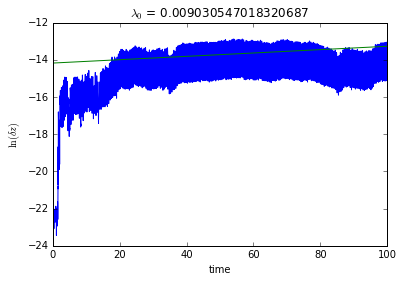

In [45]:
lambda_plot(*lyapunov_pert_theta_0(0.1, return_plottable=True))

After the initial jump up (which may be an underlying precision thing?) the two trajectories don't get further than about $1\times 10^{-13}$ apart, which I wouldn't call much in the way of growth.

So, that seems to work. Let's now try to answer the question, how does $\lambda_0$ depend on inital $\theta_0$? Let's just do 50 data points to start, so that each engine only has to run once.

In [57]:
theta_0_values = np.linspace(1.0e-8, 1.5, 50)
result = lbv.map_async(lyapunov_pert_theta_0, theta_0_values)

Now we wait for it to finish. If you expect that (a) it won't take too long, and (b) you don't have other stuff to do while you're waiting, you can either have it block until it's finished (which is roughly the same as converting `map_async` to `map_sync` after the fact) or you can use the very cool `wait_interactive` method.

In [58]:
result.wait_interactive()

  50/50 tasks finished after   22 s
done


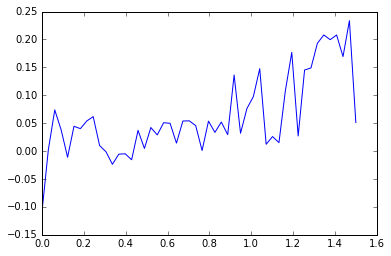

In [56]:
plt.plot(theta_0_values, result.r)

There's a lot of noise, here. Let's make use of the fact that the perturbations are in random directions to smooth that out.  If we run the same calculation multiple times (with different random perturbations of the same magnitude) and average the result, it should give us a nice, smooth plot. Let's try a single value first, to get a sense of how long it might take.

In [63]:
same_theta = 0.1*np.ones(1000)
result = lbv.map_async(lyapunov_pert_theta_0, same_theta)

In [64]:
result.wait_interactive()

1000/1000 tasks finished after  133 s
done


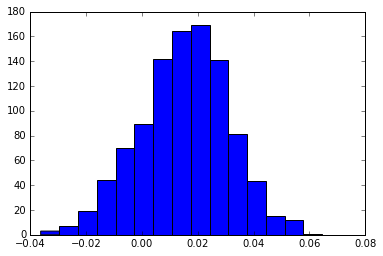

In [68]:
plt.hist(result.r, bins=15);

An ensemble of 1000 runs takes about 2 minutes, and gives us a distribution of estimated Lyapunov exponents that looks relatively Gaussian. Do we get the same kind of results at a higher initial value for $\theta_0$?

In [69]:
same_theta = 2.5*np.ones(1000)
result = lbv.map_async(lyapunov_pert_theta_0, same_theta)
result.wait_interactive()

1000/1000 tasks finished after  283 s
done


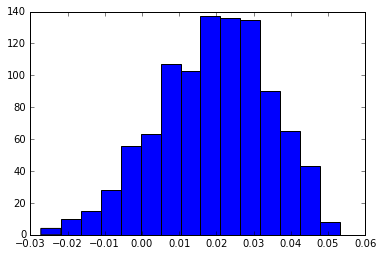

In [70]:
plt.hist(result.r, bins=15);

It takes a little more than twice as long, first of all. Second, the distribution doesn't look quite as close to Gaussian, but with only 1000 data points, it's not obvious to me how Gaussian it ought to look. The exponent is still pretty close to zero, so I can't tell just by looking at it if we've hit the chaotic regime yet.

In [74]:
same_theta = 3.0*np.ones(5000)
result = lbv.map_async(lyapunov_pert_theta_0, same_theta)
#result.wait_interactive()

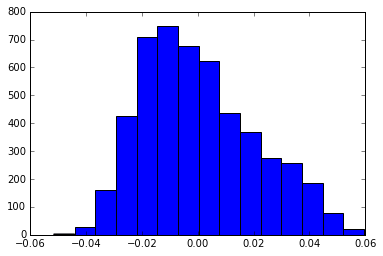

In [75]:
plt.hist(result.r, bins=15);

That really doesn't seem right. With an initial $\theta_0$ of 3.0, we ought to be in the chaotic regime, but the average value for $\lambda_0$ is really close to zero, with quite a few negative values.

In [77]:
np.mean(result.r)

0.000443413366295918

Plotting the actual data shows what is going on:

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


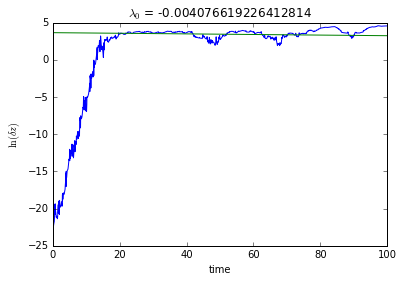

In [78]:
lambda_plot(*lyapunov_pert_theta_0(3.0, return_plottable=True))

Since I blindly set the limits to be between 20 and 80 for the curve fit, I'm actually fitting in a region where the growth has already leveled out. Clearly I need to be more clever. We should probably set limits based on y values, instead.

While work on that, some homework:

If you were going to use a single number to characterize the behavior of this model for each point in parameter space (i.e., each possible value of initial conditions), what quantity would you use? Lyapunov exponent is one possibility, but it isn't the only one.  What else should we be measuring?
